# Sentiment Analysis of Hausa, Igbo, and Yoruba Languages

In [31]:
%pip install -r requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.


In [32]:
# Import the necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re


import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, GRU,SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load Datasets

In [33]:
# Loading the datasets, stopwords, and lexicons
languages = ['hausa', 'igbo', 'yoruba']
train_data = {}
dev_data = {}
test_data = {}
stopwords = {}
lexicons = {}

for lang in languages:
    train_data[lang] = pd.read_csv(f'https://raw.githubusercontent.com/sa-diq/sentiment-analysis-Hau-Ibo-Yor-/main/data/{lang}_train.tsv', delimiter='\t')
    dev_data[lang] = pd.read_csv(f'https://raw.githubusercontent.com/sa-diq/sentiment-analysis-Hau-Ibo-Yor-/main/data/{lang}_dev.tsv', delimiter='\t')
    test_data[lang] = pd.read_csv(f'https://raw.githubusercontent.com/sa-diq/sentiment-analysis-Hau-Ibo-Yor-/main/data/{lang}_test.tsv', delimiter='\t')
    stopwords[lang] = pd.read_csv(f'https://raw.githubusercontent.com/sa-diq/sentiment-analysis-Hau-Ibo-Yor-/main/data/{lang}_stopwords.csv')
    lexicons[lang] = pd.read_csv(f'https://raw.githubusercontent.com/sa-diq/sentiment-analysis-Hau-Ibo-Yor-/main/data/{lang}_lexicon.csv')

In [34]:
# Print the first 5 rows of the hausa train data, yoruba train data, and igbo train data and their shapes
print('Hausa Train Data')
print(train_data['hausa'].head())
print(train_data['hausa'].shape)
print('\n')
print('Igbo Train Data')
print(train_data['igbo'].head())
print(train_data['igbo'].shape)
print('\n')
print('Yoruba Train Data')
print(train_data['yoruba'].head())
print(train_data['yoruba'].shape)
print('\n')

Hausa Train Data
                                               tweet     label
0  @user Da kudin da Arewa babu wani abin azo aga...  negative
1  @user Kaga wani Adu ar Banda💔😭 wai a haka Shi ...  negative
2  @user Sai haquri fa yan madrid daman kunce cha...  negative
3  @user Hmmm yanzu kai kasan girman allah daxaka...  negative
4  @user @user Wai gwamno nin Nigeria suna afa kw...  negative
(14172, 2)


Igbo Train Data
                                               tweet     label
0       Nna Ike Gwuru ooo. 😂 https://t.co/NDS7juFBGd  negative
1                 @user Chineke nna kezi mgbe ole???  negative
2  Lol. Isi adirokwanu gi nma.. 😐😒😒😒 https://t.co...  negative
3  @user haha. Fulani herdsmen. akpa amu gi retwe...  negative
4  Nna ghetto di gi na aru biko!!! https://t.co/4...  negative
(10192, 2)


Yoruba Train Data
                                               tweet     label
0  Ìwọ ikú òpònú abaradúdú wọ, o ò ṣe é 're o. O ...  negative
1  Yorùbá nbú'yàn ṣá """"""""..àyà wanle 

# DATA PREPROCESSING

In [35]:
# create a function to clean the text data
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #Removing @mentions
    text = re.sub(r'#', '', text) # Removing '#' hash tag
    text = re.sub(r'RT[\s]+', '', text) # Removing RT
    text = re.sub(r'https?:\/\/\S+', '', text) # Removing the hyper link
    text = re.sub(r'[^\w\s]', '', text) # Removing the punctuation
    text = re.sub(r'\d+', '', text) # Removing the digits
    text = re.sub(r'\bo{1,3}\b|\bò\b', '', text) # Removing 'o' or 'oo' or 'ooo' or 'ò'
    text = text.lower() # Converting the text to lower case
    return text

#  apply the clean_text function to the text data
for lang in languages:
    train_data[lang]['clean_tweet'] = train_data[lang]['tweet'].apply(clean_text)
    dev_data[lang]['clean_tweet'] = dev_data[lang]['tweet'].apply(clean_text)
    test_data[lang]['clean_tweet'] = test_data[lang]['tweet'].apply(clean_text)

In [36]:
# Print the first 5 rows of the hausa train data

print('Hausa Train Data')
display(train_data['hausa'].head())

print('\n')
print('Igbo Train Data')
display(train_data['igbo'].head())

print('\n')
print('Yoruba Train Data')
display(train_data['yoruba'].head())

print('\n')

Hausa Train Data


,tweet,label,clean_tweet
0,@user Da kudin da Arewa babu wani abin azo aga...,negative,da kudin da arewa babu wani abin azo agani da...
1,@user Kaga wani Adu ar Banda💔😭 wai a haka Shi ...,negative,kaga wani adu ar banda wai a haka shi ne shug...
2,@user Sai haquri fa yan madrid daman kunce cha...,negative,sai haquri fa yan madrid daman kunce champion...
3,@user Hmmm yanzu kai kasan girman allah daxaka...,negative,hmmm yanzu kai kasan girman allah daxakace mu...
4,@user @user Wai gwamno nin Nigeria suna afa kw...,negative,wai gwamno nin nigeria suna afa kwayoyi ko




Igbo Train Data


,tweet,label,clean_tweet
0,Nna Ike Gwuru ooo. 😂 https://t.co/NDS7juFBGd,negative,nna ike gwuru
1,@user Chineke nna kezi mgbe ole???,negative,chineke nna kezi mgbe ole
2,Lol. Isi adirokwanu gi nma.. 😐😒😒😒 https://t.co...,negative,lol isi adirokwanu gi nma
3,@user haha. Fulani herdsmen. akpa amu gi retwe...,negative,haha fulani herdsmen akpa amu gi retweet rie ...
4,Nna ghetto di gi na aru biko!!! https://t.co/4...,negative,nna ghetto di gi na aru biko




Yoruba Train Data


,tweet,label,clean_tweet
0,"Ìwọ ikú òpònú abaradúdú wọ, o ò ṣe é 're o. O ...",negative,ìwọ ikú òpònú abaradúdú wọ ṣe é re o dóró ...
1,"Yorùbá nbú'yàn ṣá """"""""""""""""..àyà wanle bí òkú ì...",negative,yorùbá nbúyàn ṣá àyà wanle bí òkú ìbànújẹ áha ...
2,"Òwe àgbà ní """"""""""""""""ọmọlọ́mọ là á rán níṣẹ́ à ...",negative,òwe àgbà ní ọmọlọmọ là á rán níṣẹ à á dé lóru ...
3,RT @user: @user asa kasa ti awon eyan ko ni od...,negative,asa kasa ti awon eyan ko ni odo awon oyinbo ...
4,RT @user: Mo ń rí àwọn èébú kọ̀ọ̀kan. Àti àwọn...,negative,mo ń rí àwọn èébú kọọkan àti àwọn tí wọn ń fi...


### Remove Stopwords

In [37]:
def remove_stopwords(data, stopwords):
    data['clean_w/o_sw'] = data['clean_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))
    return data

for lang in languages:
    train_data[lang] = remove_stopwords(train_data[lang], stopwords[lang]['word'].tolist())
    dev_data[lang] = remove_stopwords(dev_data[lang], stopwords[lang]['word'].tolist())
    test_data[lang] = remove_stopwords(test_data[lang], stopwords[lang]['word'].tolist())

In [38]:
# Print the first 5 rows of the hausa train data

print('Hausa Train Data')
display(train_data['hausa'].head())

print('\n')
print('Igbo Train Data')
display(train_data['igbo'].head())

print('\n')
print('Yoruba Train Data')
display(train_data['yoruba'].head())

print('\n')

Hausa Train Data


,tweet,label,clean_tweet,clean_w/o_sw
0,@user Da kudin da Arewa babu wani abin azo aga...,negative,da kudin da arewa babu wani abin azo agani da...,kudin arewa babu azo agani alummah isa yacucem...
1,@user Kaga wani Adu ar Banda💔😭 wai a haka Shi ...,negative,kaga wani adu ar banda wai a haka shi ne shug...,kaga adu ar banda wai shugaban sojoji gaskiya ...
2,@user Sai haquri fa yan madrid daman kunce cha...,negative,sai haquri fa yan madrid daman kunce champion...,haquri fa madrid daman kunce champion din muku...
3,@user Hmmm yanzu kai kasan girman allah daxaka...,negative,hmmm yanzu kai kasan girman allah daxakace mu...,hmmm yanzu kasan girman daxakace mukuma kune k...
4,@user @user Wai gwamno nin Nigeria suna afa kw...,negative,wai gwamno nin nigeria suna afa kwayoyi ko,wai gwamno nin nigeria suna afa kwayoyi




Igbo Train Data


,tweet,label,clean_tweet,clean_w/o_sw
0,Nna Ike Gwuru ooo. 😂 https://t.co/NDS7juFBGd,negative,nna ike gwuru,gwuru
1,@user Chineke nna kezi mgbe ole???,negative,chineke nna kezi mgbe ole,chineke kezi ole
2,Lol. Isi adirokwanu gi nma.. 😐😒😒😒 https://t.co...,negative,lol isi adirokwanu gi nma,lol adirokwanu nma
3,@user haha. Fulani herdsmen. akpa amu gi retwe...,negative,haha fulani herdsmen akpa amu gi retweet rie ...,haha fulani herdsmen akpa amu retweet rie nsi
4,Nna ghetto di gi na aru biko!!! https://t.co/4...,negative,nna ghetto di gi na aru biko,ghetto aru




Yoruba Train Data


,tweet,label,clean_tweet,clean_w/o_sw
0,"Ìwọ ikú òpònú abaradúdú wọ, o ò ṣe é 're o. O ...",negative,ìwọ ikú òpònú abaradúdú wọ ṣe é re o dóró ...,ìwọ ikú òpònú abaradúdú wọ é re dóró ṣèkà mẹni...
1,"Yorùbá nbú'yàn ṣá """"""""""""""""..àyà wanle bí òkú ì...",negative,yorùbá nbúyàn ṣá àyà wanle bí òkú ìbànújẹ áha ...,yorùbá nbúyàn ṣá àyà wanle òkú ìbànújẹ áha eeb...
2,"Òwe àgbà ní """"""""""""""""ọmọlọ́mọ là á rán níṣẹ́ à ...",negative,òwe àgbà ní ọmọlọmọ là á rán níṣẹ à á dé lóru ...,òwe àgbà ọmọlọmọ là rán níṣẹ à dé lóru wí ránm...
3,RT @user: @user asa kasa ti awon eyan ko ni od...,negative,asa kasa ti awon eyan ko ni odo awon oyinbo ...,asa kasa awon eyan ko odo awon oyinbo tiko mu ...
4,RT @user: Mo ń rí àwọn èébú kọ̀ọ̀kan. Àti àwọn...,negative,mo ń rí àwọn èébú kọọkan àti àwọn tí wọn ń fi...,èébú kọọkan yẹyẹ fiwọn sílẹ ta àwa ọwọ òs


In [39]:
for lang in languages:
    # Split the tweets into words
    words = train_data[lang]['clean_tweet'].str.split(expand=True).stack()

    # Count the number of unique words
    num_unique_words = words.nunique()

    print(f"The total number of unique words in {lang} train tweets is {num_unique_words}.")

The total number of unique words in hausa train tweets is 21811.
The total number of unique words in igbo train tweets is 15542.
The total number of unique words in yoruba train tweets is 22363.


In [40]:
# Perfrom label encoding on the label column
le = preprocessing.LabelEncoder()
for lang in languages:
    train_data[lang]['label'] = le.fit_transform(train_data[lang]['label'])
    dev_data[lang]['label'] = le.transform(dev_data[lang]['label'])
    test_data[lang]['label'] = le.transform(test_data[lang]['label'])



In [41]:
# Print the first 5 rows of the train data

print('Hausa Train Data')
display(train_data['hausa'].head())

print('\n')
print('Igbo Train Data')
display(train_data['igbo'].head())

print('\n')
print('Yoruba Train Data')
display(train_data['yoruba'].head())

print('\n')

Hausa Train Data


,tweet,label,clean_tweet,clean_w/o_sw
0,@user Da kudin da Arewa babu wani abin azo aga...,0,da kudin da arewa babu wani abin azo agani da...,kudin arewa babu azo agani alummah isa yacucem...
1,@user Kaga wani Adu ar Banda💔😭 wai a haka Shi ...,0,kaga wani adu ar banda wai a haka shi ne shug...,kaga adu ar banda wai shugaban sojoji gaskiya ...
2,@user Sai haquri fa yan madrid daman kunce cha...,0,sai haquri fa yan madrid daman kunce champion...,haquri fa madrid daman kunce champion din muku...
3,@user Hmmm yanzu kai kasan girman allah daxaka...,0,hmmm yanzu kai kasan girman allah daxakace mu...,hmmm yanzu kasan girman daxakace mukuma kune k...
4,@user @user Wai gwamno nin Nigeria suna afa kw...,0,wai gwamno nin nigeria suna afa kwayoyi ko,wai gwamno nin nigeria suna afa kwayoyi




Igbo Train Data


,tweet,label,clean_tweet,clean_w/o_sw
0,Nna Ike Gwuru ooo. 😂 https://t.co/NDS7juFBGd,0,nna ike gwuru,gwuru
1,@user Chineke nna kezi mgbe ole???,0,chineke nna kezi mgbe ole,chineke kezi ole
2,Lol. Isi adirokwanu gi nma.. 😐😒😒😒 https://t.co...,0,lol isi adirokwanu gi nma,lol adirokwanu nma
3,@user haha. Fulani herdsmen. akpa amu gi retwe...,0,haha fulani herdsmen akpa amu gi retweet rie ...,haha fulani herdsmen akpa amu retweet rie nsi
4,Nna ghetto di gi na aru biko!!! https://t.co/4...,0,nna ghetto di gi na aru biko,ghetto aru




Yoruba Train Data


,tweet,label,clean_tweet,clean_w/o_sw
0,"Ìwọ ikú òpònú abaradúdú wọ, o ò ṣe é 're o. O ...",0,ìwọ ikú òpònú abaradúdú wọ ṣe é re o dóró ...,ìwọ ikú òpònú abaradúdú wọ é re dóró ṣèkà mẹni...
1,"Yorùbá nbú'yàn ṣá """"""""""""""""..àyà wanle bí òkú ì...",0,yorùbá nbúyàn ṣá àyà wanle bí òkú ìbànújẹ áha ...,yorùbá nbúyàn ṣá àyà wanle òkú ìbànújẹ áha eeb...
2,"Òwe àgbà ní """"""""""""""""ọmọlọ́mọ là á rán níṣẹ́ à ...",0,òwe àgbà ní ọmọlọmọ là á rán níṣẹ à á dé lóru ...,òwe àgbà ọmọlọmọ là rán níṣẹ à dé lóru wí ránm...
3,RT @user: @user asa kasa ti awon eyan ko ni od...,0,asa kasa ti awon eyan ko ni odo awon oyinbo ...,asa kasa awon eyan ko odo awon oyinbo tiko mu ...
4,RT @user: Mo ń rí àwọn èébú kọ̀ọ̀kan. Àti àwọn...,0,mo ń rí àwọn èébú kọọkan àti àwọn tí wọn ń fi...,èébú kọọkan yẹyẹ fiwọn sílẹ ta àwa ọwọ òs


# DATA VISUALIZATION

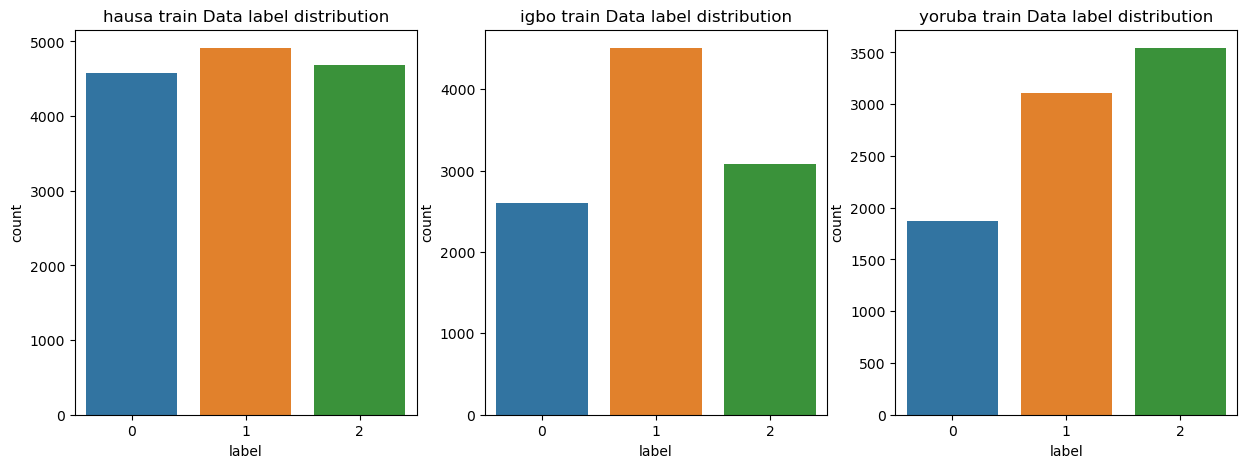

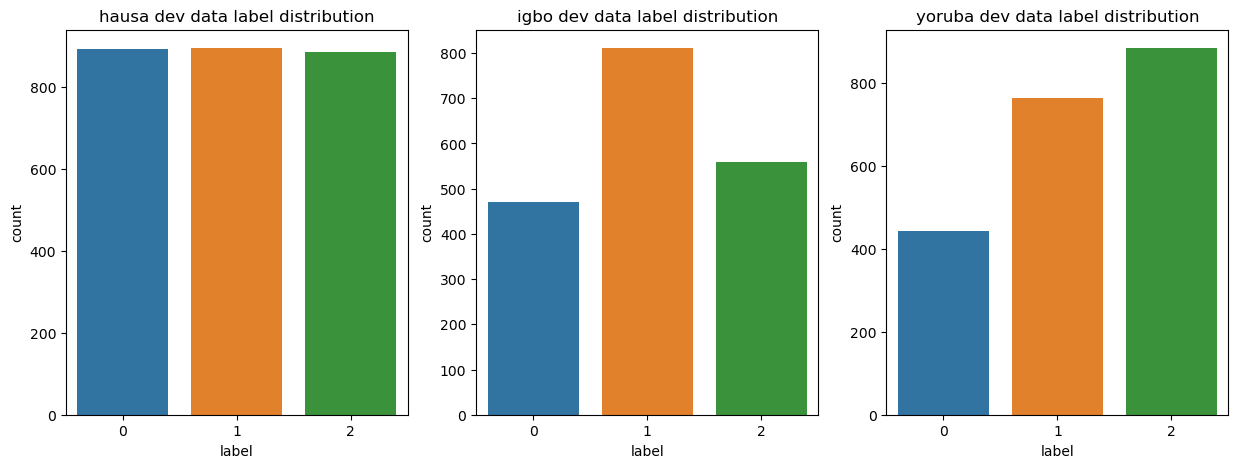

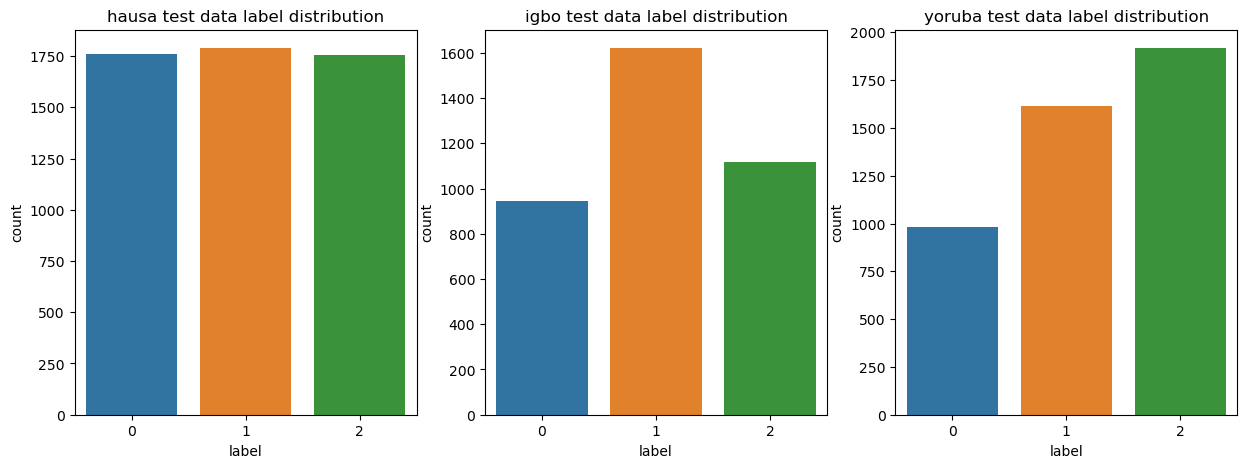

In [250]:
# Plot the distribution of the labels in the train data
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, lang in enumerate(languages):
    sns.countplot(x='label', data=train_data[lang], ax=ax[i]).set_title(f'{lang} train Data label distribution')
plt.show()

# Plot the distribution of the labels in the dev data
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, lang in enumerate(languages):
    sns.countplot(x='label', data=dev_data[lang], ax=ax[i]).set_title(f'{lang} dev data label distribution')
plt.show()
    
# Plot the distribution of the labels in the test data
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, lang in enumerate(languages):
    sns.countplot(x='label', data=test_data[lang], ax=ax[i]).set_title(f'{lang} test data label distribution')
plt.show()
    


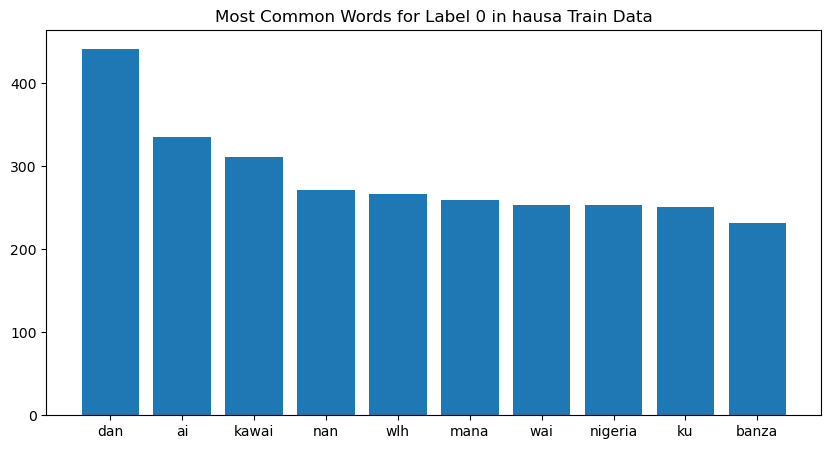

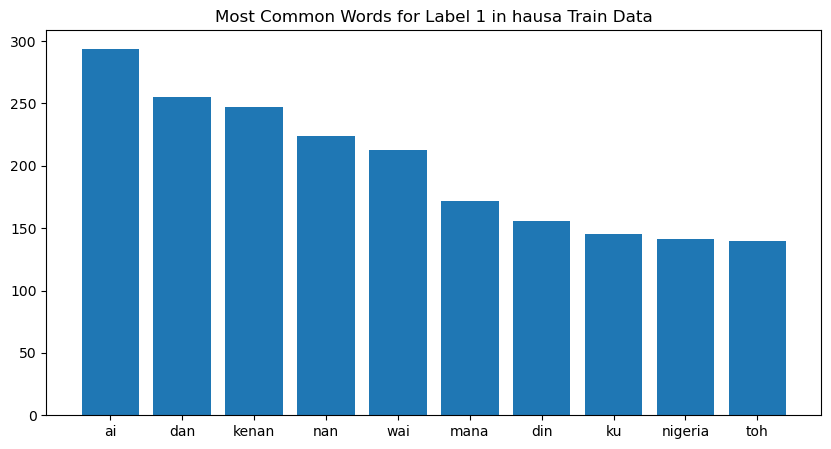

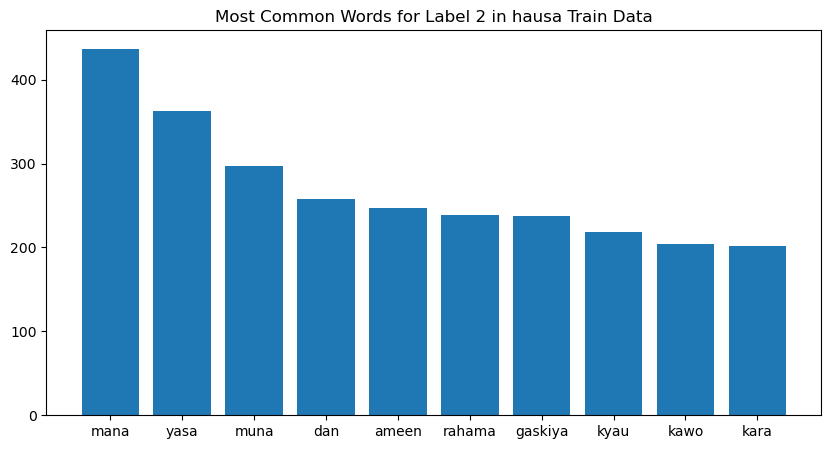

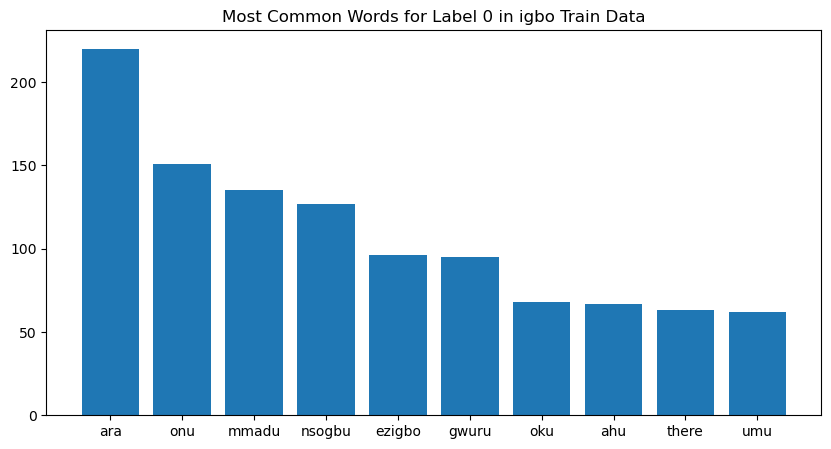

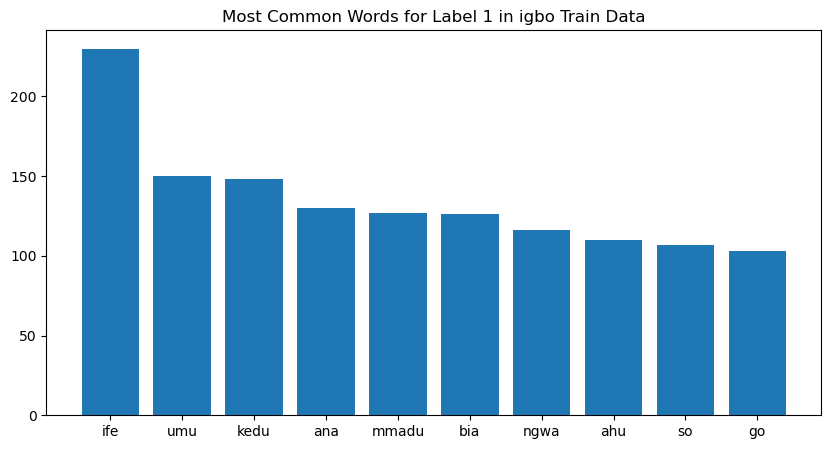

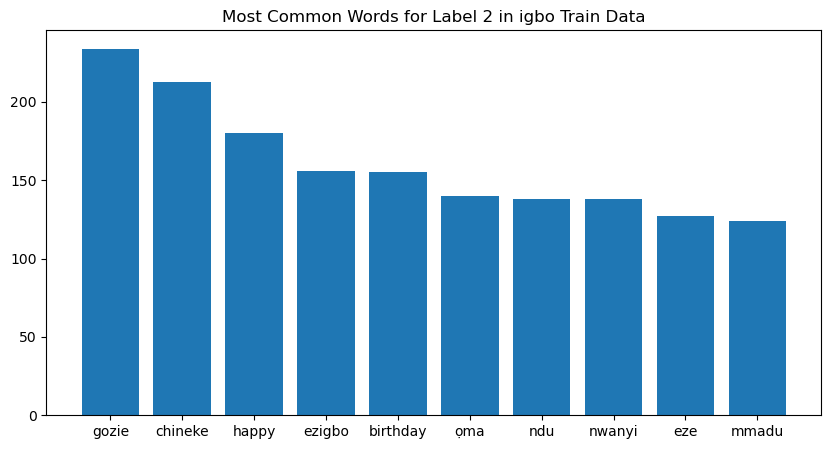

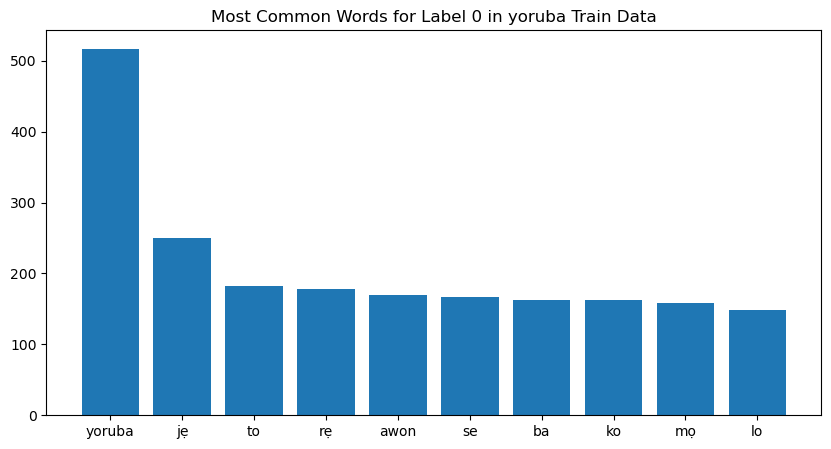

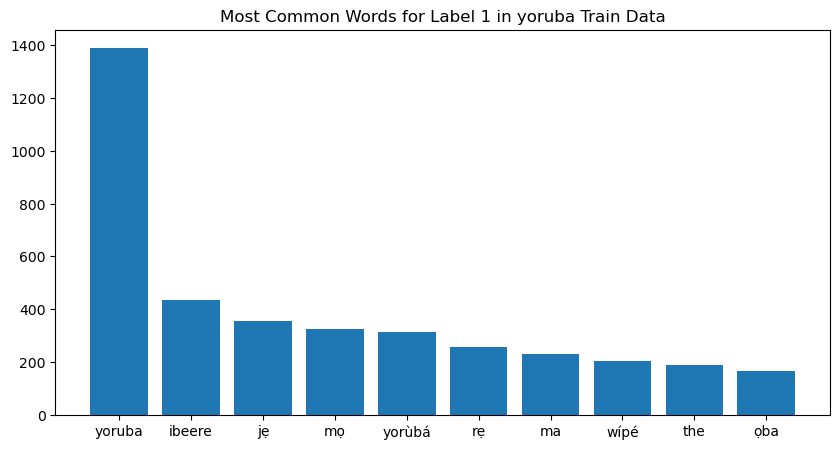

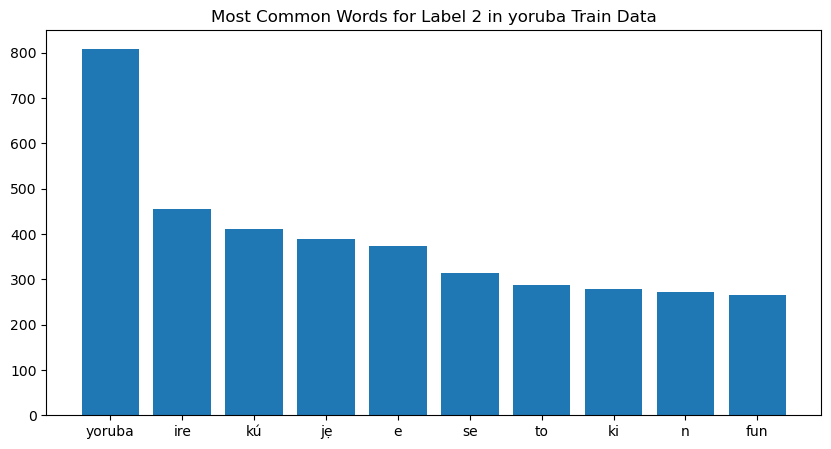

In [254]:
# Function to get most common words
def get_most_common_words(texts, n=10):
    all_words = ' '.join(texts).split()
    common_words = Counter(all_words).most_common(n)
    return common_words

# Loop over the languages
for lang in languages:
    # Loop over the sentiment labels
    for label in train_data[lang]['label'].unique():
        # Get the texts for the current label
        texts = train_data[lang][train_data[lang]['label'] == label]['clean_w/o_sw']
        
        # Get the most common words
        common_words = get_most_common_words(texts)
        
        # Plot the most common words
        plt.figure(figsize=(10, 5))
        plt.bar(*zip(*common_words))
        plt.title(f'Most Common Words for Label {label} in {lang} Train Data')
        plt.show()

### FEATURE EXTRACTION - BAG OF WORDS MODEL
- COUNT VECTORIZER
- TF-IDF

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the preprocessed text data to obtain BoW features
X_train_bow = {}
X_dev_bow = {}
X_test_bow = {}

for lang in languages:
    X_train_bow[lang] = vectorizer.fit_transform(train_data[lang]['clean_tweet'])
    X_dev_bow[lang] = vectorizer.transform(dev_data[lang]['clean_tweet'])
    X_test_bow[lang] = vectorizer.transform(test_data[lang]['clean_tweet'])

# Display the shape of the obtained feature matrices
for lang in languages:
    print(f"Shape of X_train_bow for {lang}:", X_train_bow[lang].shape)
    print(f"Shape of X_dev_bow for {lang}:", X_dev_bow[lang].shape)
    print(f"Shape of X_test_bow for {lang}:", X_test_bow[lang].shape)

Shape of X_train_bow for hausa: (14172, 21786)
Shape of X_dev_bow for hausa: (2677, 21786)
Shape of X_test_bow for hausa: (5303, 21786)
Shape of X_train_bow for igbo: (10192, 15503)
Shape of X_dev_bow for igbo: (1841, 15503)
Shape of X_test_bow for igbo: (3682, 15503)
Shape of X_train_bow for yoruba: (8522, 22317)
Shape of X_dev_bow for yoruba: (2090, 22317)
Shape of X_test_bow for yoruba: (4515, 22317)


In [43]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed text data to obtain tf-idf features
X_train_tfidf = {}
X_dev_tfidf = {}
X_test_tfidf = {}

for lang in languages:
    X_train_tfidf[lang] = tfidf_vectorizer.fit_transform(train_data[lang]['clean_tweet'])
    X_dev_tfidf[lang] = tfidf_vectorizer.transform(dev_data[lang]['clean_tweet'])
    X_test_tfidf[lang] = tfidf_vectorizer.transform(test_data[lang]['clean_tweet'])

# Display the shape of the obtained feature matrices
for lang in languages:
    print(f"Shape of X_train_tfidf for {lang}:", X_train_tfidf[lang].shape)
    print(f"Shape of X_dev_tfidf for {lang}:", X_dev_tfidf[lang].shape)
    print(f"Shape of X_test_tfidf for {lang}:", X_test_tfidf[lang].shape)

Shape of X_train_tfidf for hausa: (14172, 21786)
Shape of X_dev_tfidf for hausa: (2677, 21786)
Shape of X_test_tfidf for hausa: (5303, 21786)
Shape of X_train_tfidf for igbo: (10192, 15503)
Shape of X_dev_tfidf for igbo: (1841, 15503)
Shape of X_test_tfidf for igbo: (3682, 15503)
Shape of X_train_tfidf for yoruba: (8522, 22317)
Shape of X_dev_tfidf for yoruba: (2090, 22317)
Shape of X_test_tfidf for yoruba: (4515, 22317)


## MODELING WITH STOPWORDS

- LOGISTIC REGRESSION
- NAIVE BAYES

In [44]:
# Create a function to train a logistic regression model with the given feature matrix and labels
def train_logistic_regression(X, y):
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    return model

# Create a function to train a naive bayes model with the given feature matrix and labels
def train_naive_bayes(X, y):
    model = MultinomialNB()
    model.fit(X, y)
    return model

# Create a function to make predictions using the given model and feature matrix
def predict(model, X):
    return model.predict(X)

# Create a function to evaluate the given model using the given feature matrix and labels
def evaluate_model(model, X, y):
    y_pred = predict(model, X)
    return accuracy_score(y, y_pred)   

### Using TF-IDF Vectorizer

In [45]:
# Train and evaluate Logistic Regression model
logistic_regression_models = {}
logistic_regression_scores = {}
for lang in languages:
    model = train_logistic_regression(X_train_tfidf[lang], train_data[lang]['label'])
    logistic_regression_models[lang] = model

    train_accuracy = model.score(X_train_tfidf[lang], train_data[lang]['label'])
    dev_accuracy = model.score(X_dev_tfidf[lang], dev_data[lang]['label'])

    train_pred = model.predict(X_train_tfidf[lang])
    dev_pred = model.predict(X_dev_tfidf[lang])

    train_f1 = f1_score(train_data[lang]['label'], train_pred, average='weighted')
    dev_f1 = f1_score(dev_data[lang]['label'], dev_pred, average='weighted')

    print(f"Logistic Regression {lang}:\n"
          f"  Train Accuracy: {train_accuracy}\n"
          f"  Dev Accuracy: {dev_accuracy}\n"
          f"  Train F1: {train_f1}\n"
          f"  Dev F1: {dev_f1}\n")

# Train and evaluate Naive Bayes models
naive_bayes_models = {}
naive_bayes_scores = {}
for lang in languages:
    model = train_naive_bayes(X_train_tfidf[lang], train_data[lang]['label'])
    naive_bayes_models[lang] = model

    train_accuracy = model.score(X_train_tfidf[lang], train_data[lang]['label'])
    dev_accuracy = model.score(X_dev_tfidf[lang], dev_data[lang]['label'])

    train_pred = model.predict(X_train_tfidf[lang])
    dev_pred = model.predict(X_dev_tfidf[lang])

    train_f1 = f1_score(train_data[lang]['label'], train_pred, average='weighted')
    dev_f1 = f1_score(dev_data[lang]['label'], dev_pred, average='weighted')

    print(f"Naive Bayes {lang}:\n"
          f"  Train Accuracy: {train_accuracy}\n"
          f"  Dev Accuracy: {dev_accuracy}\n"
          f"  Train F1: {train_f1}\n"
          f"  Dev F1: {dev_f1}\n")

Logistic Regression hausa:
  Train Accuracy: 0.8777166243296641
  Dev Accuracy: 0.7411281285020546
  Train F1: 0.8779958449842123
  Dev F1: 0.7425951212248271

Logistic Regression igbo:
  Train Accuracy: 0.8794152276295133
  Dev Accuracy: 0.7756653992395437
  Train F1: 0.8787426702179341
  Dev F1: 0.7734517566326111

Logistic Regression yoruba:
  Train Accuracy: 0.8945083313776109
  Dev Accuracy: 0.7282296650717703
  Train F1: 0.8934695872082488
  Dev F1: 0.7226201914705704

Naive Bayes hausa:
  Train Accuracy: 0.885196161445103
  Dev Accuracy: 0.7119910347403811
  Train F1: 0.8853732637904413
  Dev F1: 0.7116703746191543

Naive Bayes igbo:
  Train Accuracy: 0.8296703296703297
  Dev Accuracy: 0.7289516567083107
  Train F1: 0.8250770866240541
  Dev F1: 0.716594059711598

Naive Bayes yoruba:
  Train Accuracy: 0.7749354611593523
  Dev Accuracy: 0.6588516746411484
  Train F1: 0.7489836303649237
  Dev F1: 0.6084438500952356



### Using the Count Vecorizer

In [46]:

# Train and evaluate logistic regression models
logistic_regression_models = {}
logistic_regression_scores = {}
for lang in languages:
    model = train_logistic_regression(X_train_bow[lang], train_data[lang]['label'])
    logistic_regression_models[lang] = model

    train_accuracy = model.score(X_train_bow[lang], train_data[lang]['label'])
    dev_accuracy = model.score(X_dev_bow[lang], dev_data[lang]['label'])

    train_pred = model.predict(X_train_bow[lang])
    dev_pred = model.predict(X_dev_bow[lang])

    train_f1 = f1_score(train_data[lang]['label'], train_pred, average='weighted')
    dev_f1 = f1_score(dev_data[lang]['label'], dev_pred, average='weighted')

    print(f"Logistic Regression {lang}:\n"
          f"  Train Accuracy: {train_accuracy}\n"
          f"  Dev Accuracy: {dev_accuracy}\n"
          f"  Train F1: {train_f1}\n"
          f"  Dev F1: {dev_f1}\n")

# Train and evaluate naive bayes models
naive_bayes_models = {}
naive_bayes_scores = {}
for lang in languages:
    model = train_naive_bayes(X_train_bow[lang], train_data[lang]['label'])
    naive_bayes_models[lang] = model

    train_accuracy = model.score(X_train_bow[lang], train_data[lang]['label'])
    dev_accuracy = model.score(X_dev_bow[lang], dev_data[lang]['label'])

    train_pred = model.predict(X_train_bow[lang])
    dev_pred = model.predict(X_dev_bow[lang])

    train_f1 = f1_score(train_data[lang]['label'], train_pred, average='weighted')
    dev_f1 = f1_score(dev_data[lang]['label'], dev_pred, average='weighted')

    print(f"Naive Bayes {lang}:\n"
          f"  Train Accuracy: {train_accuracy}\n"
          f"  Dev Accuracy: {dev_accuracy}\n"
          f"  Train F1: {train_f1}\n"
          f"  Dev F1: {dev_f1}\n")

Logistic Regression hausa:
  Train Accuracy: 0.9575924357888794
  Dev Accuracy: 0.7415016809861785
  Train F1: 0.9576414307765619
  Dev F1: 0.7422152658896894

Logistic Regression igbo:
  Train Accuracy: 0.9489795918367347
  Dev Accuracy: 0.77729494839761
  Train F1: 0.9489242039418783
  Dev F1: 0.7767956415068492

Logistic Regression yoruba:
  Train Accuracy: 0.9888523820699366
  Dev Accuracy: 0.7339712918660287
  Train F1: 0.9888457022002426
  Dev F1: 0.7303439730866059

Naive Bayes hausa:
  Train Accuracy: 0.8688964154671183
  Dev Accuracy: 0.7071348524467688
  Train F1: 0.8689547082690047
  Dev F1: 0.7040037086472846

Naive Bayes igbo:
  Train Accuracy: 0.8780416012558869
  Dev Accuracy: 0.755024443237371
  Train F1: 0.8773119280962959
  Dev F1: 0.7499454746454988

Naive Bayes yoruba:
  Train Accuracy: 0.8705702886646327
  Dev Accuracy: 0.722488038277512
  Train F1: 0.8702229577446456
  Dev F1: 0.7160332587225354



### Evaluating Moddels on Test data
- TF-IDF

In [47]:
# Predict the labels of the test data using the logistic regression models
logistic_regression_test_preds = {}
for lang in languages:
    model = logistic_regression_models[lang]
    logistic_regression_test_preds[lang] = model.predict(X_test_tfidf[lang])

# Predict the labels of the test data using the naive bayes models
naive_bayes_test_preds = {}
for lang in languages:
    model = naive_bayes_models[lang]
    naive_bayes_test_preds[lang] = model.predict(X_test_tfidf[lang])

# Print the classification report for the logistic regression models
for lang in languages:
    print(f"Classification Report for Logistic Regression {lang}:\n", classification_report(test_data[lang]['label'], logistic_regression_test_preds[lang]))
    
# Print the classification report for the naive bayes models
for lang in languages:
    print(f"Classification Report for Naive Bayes {lang}:\n", classification_report(test_data[lang]['label'], naive_bayes_test_preds[lang]))
    

Classification Report for Logistic Regression hausa:
               precision    recall  f1-score   support

           0       0.90      0.23      0.36      1759
           1       0.41      0.99      0.58      1789
           2       0.98      0.33      0.49      1755

    accuracy                           0.52      5303
   macro avg       0.76      0.51      0.48      5303
weighted avg       0.76      0.52      0.48      5303

Classification Report for Logistic Regression igbo:
               precision    recall  f1-score   support

           0       0.81      0.57      0.67       943
           1       0.63      0.94      0.75      1621
           2       0.95      0.51      0.67      1118

    accuracy                           0.71      3682
   macro avg       0.80      0.67      0.70      3682
weighted avg       0.77      0.71      0.70      3682

Classification Report for Logistic Regression yoruba:
               precision    recall  f1-score   support

           0       0.

### Evaluating Moddels on Test data
- Count Vectorizer

In [48]:
# Predict the labels of the test data using the logistic regression models
logistic_regression_test_preds = {}
for lang in languages:
    model = logistic_regression_models[lang]
    logistic_regression_test_preds[lang] = model.predict(X_test_bow[lang])

# Predict the labels of the test data using the naive bayes models
naive_bayes_test_preds = {}
for lang in languages:
    model = naive_bayes_models[lang]
    naive_bayes_test_preds[lang] = model.predict(X_test_bow[lang])

# Print the classification report for the logistic regression models
for lang in languages:
    print(f"Classification Report for Logistic Regression {lang}:\n", classification_report(test_data[lang]['label'], logistic_regression_test_preds[lang]))
    
# Print the classification report for the naive bayes models
for lang in languages:
    print(f"Classification Report for Naive Bayes {lang}:\n", classification_report(test_data[lang]['label'], naive_bayes_test_preds[lang]))
    

Classification Report for Logistic Regression hausa:
               precision    recall  f1-score   support

           0       0.77      0.65      0.71      1759
           1       0.67      0.80      0.73      1789
           2       0.83      0.81      0.82      1755

    accuracy                           0.75      5303
   macro avg       0.76      0.75      0.75      5303
weighted avg       0.76      0.75      0.75      5303

Classification Report for Logistic Regression igbo:
               precision    recall  f1-score   support

           0       0.74      0.67      0.71       943
           1       0.75      0.84      0.79      1621
           2       0.86      0.78      0.82      1118

    accuracy                           0.78      3682
   macro avg       0.78      0.76      0.77      3682
weighted avg       0.78      0.78      0.78      3682

Classification Report for Logistic Regression yoruba:
               precision    recall  f1-score   support

           0       0.

### MODELING WITHOUT STOPWORDS


In [49]:
# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the preprocessed text data to obtain BoW features
X_train_bow = {}
X_dev_bow = {}
X_test_bow = {}

for lang in languages:
    X_train_bow[lang] = vectorizer.fit_transform(train_data[lang]['clean_w/o_sw'])
    X_dev_bow[lang] = vectorizer.transform(dev_data[lang]['clean_w/o_sw'])
    X_test_bow[lang] = vectorizer.transform(test_data[lang]['clean_w/o_sw'])

# Display the shape of the obtained feature matrices
for lang in languages:
    print(f"Shape of X_train_bow for {lang}:", X_train_bow[lang].shape)
    print(f"Shape of X_dev_bow for {lang}:", X_dev_bow[lang].shape)
    print(f"Shape of X_test_bow for {lang}:", X_test_bow[lang].shape)

Shape of X_train_bow for hausa: (14172, 21726)
Shape of X_dev_bow for hausa: (2677, 21726)
Shape of X_test_bow for hausa: (5303, 21726)
Shape of X_train_bow for igbo: (10192, 15450)
Shape of X_dev_bow for igbo: (1841, 15450)
Shape of X_test_bow for igbo: (3682, 15450)
Shape of X_train_bow for yoruba: (8522, 22269)
Shape of X_dev_bow for yoruba: (2090, 22269)
Shape of X_test_bow for yoruba: (4515, 22269)


In [50]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed text data to obtain tf-idf features
X_train_tfidf = {}
X_dev_tfidf = {}
X_test_tfidf = {}

for lang in languages:
    X_train_tfidf[lang] = tfidf_vectorizer.fit_transform(train_data[lang]['clean_w/o_sw'])
    X_dev_tfidf[lang] = tfidf_vectorizer.transform(dev_data[lang]['clean_w/o_sw'])
    X_test_tfidf[lang] = tfidf_vectorizer.transform(test_data[lang]['clean_w/o_sw'])

# Display the shape of the obtained feature matrices
for lang in languages:
    print(f"Shape of X_train_tfidf for {lang}:", X_train_tfidf[lang].shape)
    print(f"Shape of X_dev_tfidf for {lang}:", X_dev_tfidf[lang].shape)
    print(f"Shape of X_test_tfidf for {lang}:", X_test_tfidf[lang].shape)

Shape of X_train_tfidf for hausa: (14172, 21726)
Shape of X_dev_tfidf for hausa: (2677, 21726)
Shape of X_test_tfidf for hausa: (5303, 21726)
Shape of X_train_tfidf for igbo: (10192, 15450)
Shape of X_dev_tfidf for igbo: (1841, 15450)
Shape of X_test_tfidf for igbo: (3682, 15450)
Shape of X_train_tfidf for yoruba: (8522, 22269)
Shape of X_dev_tfidf for yoruba: (2090, 22269)
Shape of X_test_tfidf for yoruba: (4515, 22269)


### Define Model Training and Evaluation Functions

In [51]:
# Create a function to train a logistic regression model with the given feature matrix and labels
def train_logistic_regression(X, y):
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    return model

# Create a function to train a naive bayes model with the given feature matrix and labels
def train_naive_bayes(X, y):
    model = MultinomialNB()
    model.fit(X, y)
    return model

# Create a function to make predictions using the given model and feature matrix
def predict(model, X):
    return model.predict(X)

# Create a function to evaluate the given model using the given feature matrix and labels
def evaluate_model(model, X, y):
    y_pred = predict(model, X)
    return accuracy_score(y, y_pred)   

### Modeling with TF-IDF

In [52]:

# Train and evaluate logistic regression models
logistic_regression_models = {}
logistic_regression_scores = {}
for lang in languages:
    model = train_logistic_regression(X_train_tfidf[lang], train_data[lang]['label'])
    logistic_regression_models[lang] = model

    train_accuracy = model.score(X_train_tfidf[lang], train_data[lang]['label'])
    dev_accuracy = model.score(X_dev_tfidf[lang], dev_data[lang]['label'])

    train_pred = model.predict(X_train_tfidf[lang])
    dev_pred = model.predict(X_dev_tfidf[lang])

    train_f1 = f1_score(train_data[lang]['label'], train_pred, average='weighted')
    dev_f1 = f1_score(dev_data[lang]['label'], dev_pred, average='weighted')

    print(f"Logistic Regression {lang}:\n"
          f"  Train Accuracy: {train_accuracy}\n"
          f"  Dev Accuracy: {dev_accuracy}\n"
          f"  Train F1: {train_f1}\n"
          f"  Dev F1: {dev_f1}\n")

# Train and evaluate naive bayes models
naive_bayes_models = {}
naive_bayes_scores = {}
for lang in languages:
    model = train_naive_bayes(X_train_tfidf[lang], train_data[lang]['label'])
    naive_bayes_models[lang] = model

    train_accuracy = model.score(X_train_tfidf[lang], train_data[lang]['label'])
    dev_accuracy = model.score(X_dev_tfidf[lang], dev_data[lang]['label'])

    train_pred = model.predict(X_train_tfidf[lang])
    dev_pred = model.predict(X_dev_tfidf[lang])

    train_f1 = f1_score(train_data[lang]['label'], train_pred, average='weighted')
    dev_f1 = f1_score(dev_data[lang]['label'], dev_pred, average='weighted')

    print(f"Naive Bayes {lang}:\n"
          f"  Train Accuracy: {train_accuracy}\n"
          f"  Dev Accuracy: {dev_accuracy}\n"
          f"  Train F1: {train_f1}\n"
          f"  Dev F1: {dev_f1}\n")

Logistic Regression hausa:
  Train Accuracy: 0.8866073948631104
  Dev Accuracy: 0.7015315651849084
  Train F1: 0.8868888391453321
  Dev F1: 0.7029105150706791

Logistic Regression igbo:
  Train Accuracy: 0.8783359497645212
  Dev Accuracy: 0.7419880499728408
  Train F1: 0.8775596518724665
  Dev F1: 0.7378588950446376

Logistic Regression yoruba:
  Train Accuracy: 0.9135179535320347
  Dev Accuracy: 0.7129186602870813
  Train F1: 0.9126952186150823
  Dev F1: 0.705114056094667

Naive Bayes hausa:
  Train Accuracy: 0.8833615580016935
  Dev Accuracy: 0.6970489353754202
  Train F1: 0.8835064840970468
  Dev F1: 0.6970534160944375

Naive Bayes igbo:
  Train Accuracy: 0.8443877551020408
  Dev Accuracy: 0.7218902770233568
  Train F1: 0.8419764430094672
  Dev F1: 0.7120118783140176

Naive Bayes yoruba:
  Train Accuracy: 0.7992255339122272
  Dev Accuracy: 0.6578947368421053
  Train F1: 0.7804989161140935
  Dev F1: 0.6131479885194727



### Evaluation on Test Set

In [ ]:
# Predict the labels of the test data using the logistic regression models
logistic_regression_test_preds = {}
for lang in languages:
    model = logistic_regression_models[lang]
    logistic_regression_test_preds[lang] = model.predict(X_test_tfidf[lang])

# Predict the labels of the test data using the naive bayes models
naive_bayes_test_preds = {}
for lang in languages:
    model = naive_bayes_models[lang]
    naive_bayes_test_preds[lang] = model.predict(X_test_tfidf[lang])

# Print the classification report for the logistic regression models
for lang in languages:
    print(f"Classification Report for Logistic Regression {lang}:\n", classification_report(test_data[lang]['label'], logistic_regression_test_preds[lang]))
    
# Print the classification report for the naive bayes models
for lang in languages:
    print(f"Classification Report for Naive Bayes {lang}:\n", classification_report(test_data[lang]['label'], naive_bayes_test_preds[lang]))
    

### Modeling with Count Vectorizer

In [30]:
# Train and evaluate logistic regression models
logistic_regression_models = {}
logistic_regression_scores = {}
for lang in languages:
    model = train_logistic_regression(X_train_bow[lang], train_data[lang]['label'])
    logistic_regression_models[lang] = model

    train_accuracy = model.score(X_train_bow[lang], train_data[lang]['label'])
    dev_accuracy = model.score(X_dev_bow[lang], dev_data[lang]['label'])

    train_pred = model.predict(X_train_bow[lang])
    dev_pred = model.predict(X_dev_bow[lang])

    train_f1 = f1_score(train_data[lang]['label'], train_pred, average='weighted')
    dev_f1 = f1_score(dev_data[lang]['label'], dev_pred, average='weighted')

    print(f"Logistic Regression {lang}:\n"
          f"  Train Accuracy: {train_accuracy}\n"
          f"  Dev Accuracy: {dev_accuracy}\n"
          f"  Train F1: {train_f1}\n"
          f"  Dev F1: {dev_f1}\n")

# Train and evaluate naive bayes models
naive_bayes_models = {}
naive_bayes_scores = {}
for lang in languages:
    model = train_naive_bayes(X_train_bow[lang], train_data[lang]['label'])
    naive_bayes_models[lang] = model

    train_accuracy = model.score(X_train_bow[lang], train_data[lang]['label'])
    dev_accuracy = model.score(X_dev_bow[lang], dev_data[lang]['label'])

    train_pred = model.predict(X_train_bow[lang])
    dev_pred = model.predict(X_dev_bow[lang])

    train_f1 = f1_score(train_data[lang]['label'], train_pred, average='weighted')
    dev_f1 = f1_score(dev_data[lang]['label'], dev_pred, average='weighted')

    print(f"Naive Bayes {lang}:\n"
          f"  Train Accuracy: {train_accuracy}\n"
          f"  Dev Accuracy: {dev_accuracy}\n"
          f"  Train F1: {train_f1}\n"
          f"  Dev F1: {dev_f1}\n")

Logistic Regression hausa:
  Train Accuracy: 0.9528648038385549
  Dev Accuracy: 0.7119910347403811
  Train F1: 0.9529677962476578
  Dev F1: 0.7134524460883818

Logistic Regression igbo:
  Train Accuracy: 0.9399529042386185
  Dev Accuracy: 0.7387289516567083
  Train F1: 0.9398806069797435
  Dev F1: 0.7369729254695583

Logistic Regression yoruba:
  Train Accuracy: 0.9889697254165689
  Dev Accuracy: 0.7311004784688995
  Train F1: 0.9889652417962265
  Dev F1: 0.7269863544882406

Naive Bayes hausa:
  Train Accuracy: 0.8732006773920407
  Dev Accuracy: 0.6892043332088158
  Train F1: 0.8732085350968248
  Dev F1: 0.6866137617828283

Naive Bayes igbo:
  Train Accuracy: 0.8740188383045526
  Dev Accuracy: 0.7300380228136882
  Train F1: 0.8734829901376021
  Dev F1: 0.7256495982012163

Naive Bayes yoruba:
  Train Accuracy: 0.8895799108190565
  Dev Accuracy: 0.7148325358851675
  Train F1: 0.8892197660203095
  Dev F1: 0.708627416641319



### Evaluation on Test Set

In [54]:
# Predict the labels of the test data using the logistic regression models
logistic_regression_test_preds = {}
for lang in languages:
    model = logistic_regression_models[lang]
    logistic_regression_test_preds[lang] = model.predict(X_test_bow[lang])

# Predict the labels of the test data using the naive bayes models
naive_bayes_test_preds = {}
for lang in languages:
    model = naive_bayes_models[lang]
    naive_bayes_test_preds[lang] = model.predict(X_test_bow[lang])

# Print the classification report for the logistic regression models
for lang in languages:
    print(f"Classification Report for Logistic Regression {lang}:\n", classification_report(test_data[lang]['label'], logistic_regression_test_preds[lang]))
    
# Print the classification report for the naive bayes models
for lang in languages:
    print(f"Classification Report for Naive Bayes {lang}:\n", classification_report(test_data[lang]['label'], naive_bayes_test_preds[lang]))
    

Classification Report for Logistic Regression hausa:
               precision    recall  f1-score   support

           0       0.63      0.77      0.69      1759
           1       0.70      0.52      0.59      1789
           2       0.75      0.79      0.77      1755

    accuracy                           0.69      5303
   macro avg       0.69      0.69      0.69      5303
weighted avg       0.69      0.69      0.68      5303

Classification Report for Logistic Regression igbo:
               precision    recall  f1-score   support

           0       0.73      0.64      0.68       943
           1       0.73      0.75      0.74      1621
           2       0.74      0.78      0.76      1118

    accuracy                           0.73      3682
   macro avg       0.73      0.73      0.73      3682
weighted avg       0.73      0.73      0.73      3682

Classification Report for Logistic Regression yoruba:
               precision    recall  f1-score   support

           0       0.

No major significance in the performance of the models with or without stopwords.

### Plotting top 30 words in the training set for each langauge

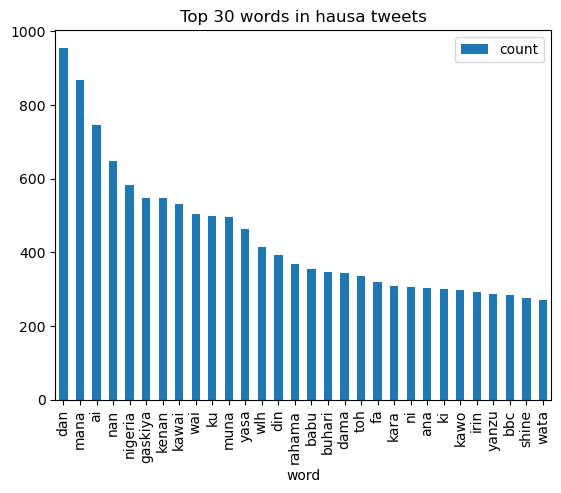

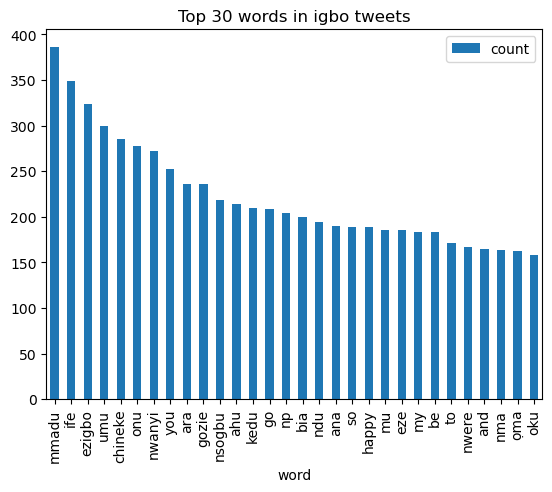

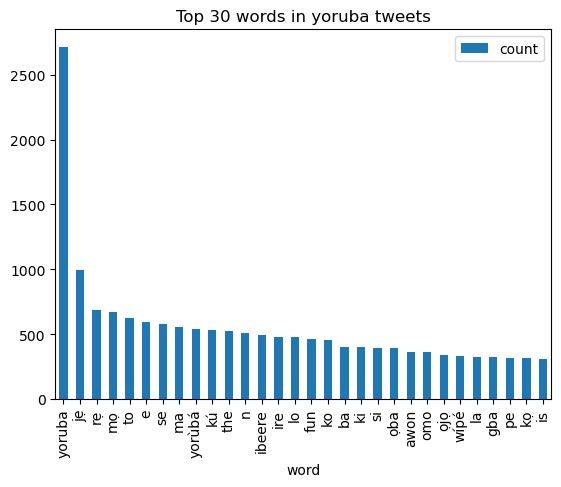

In [56]:
from collections import Counter

for lang in languages:
    # Split the tweets into words
    words = train_data[lang]['clean_w/o_sw'].str.split(expand=True).stack()

    # Count the words
    word_counts = Counter(words)

    # Get the 30 most common words
    common_words = word_counts.most_common(30)

    # Convert the list of tuples into a DataFrame
    df = pd.DataFrame(common_words, columns=['word', 'count'])

    # Plot the word counts
    df.plot(kind='bar', x='word', y='count', title=f"Top 30 words in {lang} tweets")
    plt.show()

In [79]:
import re

# List of words to remove
remove_words = ['yoruba', 'yorùbá' , 'to', 'the', 'is']

# Create a regular expression pattern with word boundaries
pattern = r'\b(' + '|'.join(remove_words) + r')\b'

# Remove the words from the Yoruba corpus
train_data['yoruba']['extra_clean'] = train_data['yoruba']['clean_w/o_sw'].str.replace(pattern, '', regex=True, case=False)

In [80]:
test_data['yoruba']['extra_clean'] = test_data['yoruba']['clean_w/o_sw'].str.replace(pattern, '', regex=True, case=False)

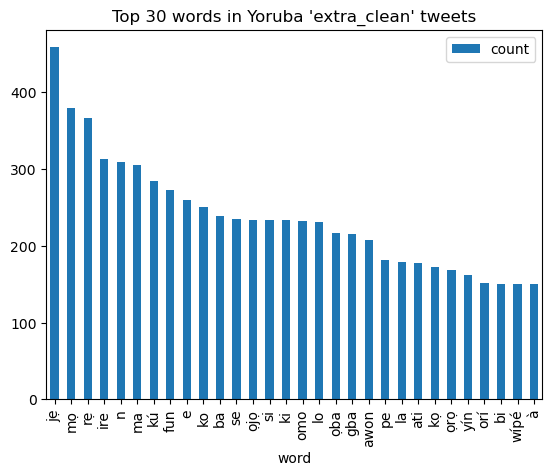

In [82]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Split the tweets into words
words = test_data['yoruba']['extra_clean'].str.split(expand=True).stack()

# Count the words
word_counts = Counter(words)

# Get the 30 most common words
common_words = word_counts.most_common(30)

# Convert the list of tuples into a DataFrame
df = pd.DataFrame(common_words, columns=['word', 'count'])

# Plot the word counts
df.plot(kind='bar', x='word', y='count', title="Top 30 words in Yoruba 'extra_clean' tweets")
plt.show()

In [226]:
X_train_bow_new = {}
X_test_bow_new = {}
tf = TfidfVectorizer(max_features=20000, min_df=5)

# Fit the vectorizer on the training data and transform it
X_train_bow_new['yoruba'] = tf.fit_transform(train_data['yoruba']['extra_clean'])

# Transform the test data using the same vectorizer
X_test_bow_new['yoruba'] = tf.transform(test_data['yoruba']['extra_clean'])

In [227]:
print(X_train_bow_new['yoruba'].shape)
print(X_test_bow_new['yoruba'].shape)

(8522, 3283)
(4515, 3283)


In [232]:
lr = LogisticRegression(max_iter=1000, penalty='l2', solver='liblinear', C=3)
lr.fit(X_train_bow_new['yoruba'], train_data['yoruba']['label'])

train_accuracy = lr.score(X_train_bow_new['yoruba'], train_data['yoruba']['label'])
print(f"Train Accuracy: {train_accuracy}") 


Train Accuracy: 0.8622389110537433


In [233]:
# Predict with the test data
test_preds = lr.predict(X_test_bow_new['yoruba'])

# Print the classification report
print(classification_report(test_data['yoruba']['label'], test_preds))



              precision    recall  f1-score   support

           0       0.62      0.50      0.55       981
           1       0.68      0.72      0.70      1616
           2       0.76      0.80      0.78      1918

    accuracy                           0.71      4515
   macro avg       0.69      0.67      0.68      4515
weighted avg       0.70      0.71      0.70      4515



## STACKING CLASSIFIER
- Stacking Logistic Regression and Naive Bayes Model

In [239]:
# Define the base models
base_models = [
    ('logistic_regression', LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=1)),
    ('naive_bayes', MultinomialNB(alpha=1))
]

# Define the meta-model
meta_model = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=1)

# Define the stacking classifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Create a pipeline that transforms the data, trains the base models, and then trains the meta-model
pipeline = make_pipeline(TfidfVectorizer(), stacking_classifier)

# Dictionary to store the pipelines for each language
pipelines = {}

# Loop over the languages
for lang in languages:
    # Clone the pipeline
    pipeline_clone = clone(pipeline)
    
    # Train the pipeline on the training data
    pipeline_clone.fit(train_data[lang]['clean_w/o_sw'], train_data[lang]['label'])
    
    # Store the pipeline
    pipelines[lang] = pipeline_clone

# Make predictions with the test data
predictions = {lang: pipelines[lang].predict(test_data[lang]['clean_w/o_sw']) for lang in languages}



### Evaluating the Stacking classifier Model on the Test Data

In [240]:
from sklearn.metrics import accuracy_score, f1_score

# Loop over the languages
for lang in languages:
    # Calculate the accuracy
    accuracy = accuracy_score(test_data[lang]['label'], predictions[lang])
    
    # Calculate the F1 score
    f1 = f1_score(test_data[lang]['label'], predictions[lang], average='weighted')
    
    print(f"Results for {lang}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print("\n")

Results for hausa:
Accuracy: 0.7297755987177069
F1 Score: 0.7305804436578271


Results for igbo:
Accuracy: 0.7561108093427485
F1 Score: 0.753683834287036


Results for yoruba:
Accuracy: 0.7122923588039867
F1 Score: 0.7068909012729293




## Removing the English Stopwords from the Datasets

In [255]:
# Download the stopwords from nltk
nltk.download('stopwords')

# Get the English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from text
def remove_stopwords(text):
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return ' '.join(filtered_text)

# Loop over the languages
for lang in languages:
    # Remove stopwords from the text and create a new column
    train_data[lang]['text_without_stopwords'] = train_data[lang]['clean_w/o_sw'].apply(remove_stopwords)
    dev_data[lang]['text_without_stopwords'] = dev_data[lang]['clean_w/o_sw'].apply(remove_stopwords)
    test_data[lang]['text_without_stopwords'] = test_data[lang]['clean_w/o_sw'].apply(remove_stopwords)
    


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [263]:
# Create a function to train a logistic regression model with the given feature matrix and labels
def train_logistic_regression(X, y):
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    return model

# Create a function to train a naive bayes model with the given feature matrix and labels
def train_naive_bayes(X, y):
    model = MultinomialNB()
    model.fit(X, y)
    return model

In [264]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the preprocessed text data to obtain tf-idf features
X_train_tfidf = {}
X_dev_tfidf = {}
X_test_tfidf = {}

for lang in languages:
    X_train_tfidf[lang] = tfidf_vectorizer.fit_transform(train_data[lang]['text_without_stopwords'])
    X_dev_tfidf[lang] = tfidf_vectorizer.transform(dev_data[lang]['text_without_stopwords'])
    X_test_tfidf[lang] = tfidf_vectorizer.transform(test_data[lang]['text_without_stopwords'])

# Display the shape of the obtained feature matrices
for lang in languages:
    print(f"Shape of X_train_tfidf for {lang}:", X_train_tfidf[lang].shape)
    print(f"Shape of X_dev_tfidf for {lang}:", X_dev_tfidf[lang].shape)
    print(f"Shape of X_test_tfidf for {lang}:", X_test_tfidf[lang].shape)

Shape of X_train_tfidf for hausa: (14172, 21617)
Shape of X_dev_tfidf for hausa: (2677, 21617)
Shape of X_test_tfidf for hausa: (5303, 21617)
Shape of X_train_tfidf for igbo: (10192, 15338)
Shape of X_dev_tfidf for igbo: (1841, 15338)
Shape of X_test_tfidf for igbo: (3682, 15338)
Shape of X_train_tfidf for yoruba: (8522, 22147)
Shape of X_dev_tfidf for yoruba: (2090, 22147)
Shape of X_test_tfidf for yoruba: (4515, 22147)


In [265]:
# Train and evaluate logistic regression models
logistic_regression_models = {}
logistic_regression_scores = {}
for lang in languages:
    model = train_logistic_regression(X_train_tfidf[lang], train_data[lang]['label'])
    logistic_regression_models[lang] = model

    train_accuracy = model.score(X_train_tfidf[lang], train_data[lang]['label'])
    dev_accuracy = model.score(X_dev_tfidf[lang], dev_data[lang]['label'])

    train_pred = model.predict(X_train_tfidf[lang])
    dev_pred = model.predict(X_dev_tfidf[lang])

    train_f1 = f1_score(train_data[lang]['label'], train_pred, average='weighted')
    dev_f1 = f1_score(dev_data[lang]['label'], dev_pred, average='weighted')

    print(f"Logistic Regression {lang}:\n"
          f"  Train Accuracy: {train_accuracy}\n"
          f"  Dev Accuracy: {dev_accuracy}\n"
          f"  Train F1: {train_f1}\n"
          f"  Dev F1: {dev_f1}\n")

# Train and evaluate naive bayes models
naive_bayes_models = {}
naive_bayes_scores = {}
for lang in languages:
    model = train_naive_bayes(X_train_tfidf[lang], train_data[lang]['label'])
    naive_bayes_models[lang] = model

    train_accuracy = model.score(X_train_tfidf[lang], train_data[lang]['label'])
    dev_accuracy = model.score(X_dev_tfidf[lang], dev_data[lang]['label'])

    train_pred = model.predict(X_train_tfidf[lang])
    dev_pred = model.predict(X_dev_tfidf[lang])

    train_f1 = f1_score(train_data[lang]['label'], train_pred, average='weighted')
    dev_f1 = f1_score(dev_data[lang]['label'], dev_pred, average='weighted')

    print(f"Naive Bayes {lang}:\n"
          f"  Train Accuracy: {train_accuracy}\n"
          f"  Dev Accuracy: {dev_accuracy}\n"
          f"  Train F1: {train_f1}\n"
          f"  Dev F1: {dev_f1}\n")

Logistic Regression hausa:
  Train Accuracy: 0.8845611064069997
  Dev Accuracy: 0.6985431453119163
  Train F1: 0.8848673770735492
  Dev F1: 0.7001348898430287

Logistic Regression igbo:
  Train Accuracy: 0.8797095761381476
  Dev Accuracy: 0.7403585008147746
  Train F1: 0.8789894796803916
  Dev F1: 0.7366925458649201

Logistic Regression yoruba:
  Train Accuracy: 0.9164515371978409
  Dev Accuracy: 0.7114832535885167
  Train F1: 0.9156434328880769
  Dev F1: 0.7033743726807844

Naive Bayes hausa:
  Train Accuracy: 0.8842788597233983
  Dev Accuracy: 0.6974224878595443
  Train F1: 0.8844679842454011
  Dev F1: 0.6978403596474724

Naive Bayes igbo:
  Train Accuracy: 0.8520408163265306
  Dev Accuracy: 0.7213470939706681
  Train F1: 0.8500465128060982
  Dev F1: 0.7123165944826468

Naive Bayes yoruba:
  Train Accuracy: 0.8066181647500587
  Dev Accuracy: 0.6583732057416268
  Train F1: 0.7895575321149076
  Dev F1: 0.6139972388694188



### Evaluate Models on Test Set

In [266]:
# Predict the labels of the test data using the logistic regression models
logistic_regression_test_preds = {}
for lang in languages:
    model = logistic_regression_models[lang]
    logistic_regression_test_preds[lang] = model.predict(X_test_tfidf[lang])

# Predict the labels of the test data using the naive bayes models
naive_bayes_test_preds = {}
for lang in languages:
    model = naive_bayes_models[lang]
    naive_bayes_test_preds[lang] = model.predict(X_test_tfidf[lang])

# Print the classification report for the logistic regression models
for lang in languages:
    print(f"Classification Report for Logistic Regression {lang}:\n", classification_report(test_data[lang]['label'], logistic_regression_test_preds[lang]))
    
# Print the classification report for the naive bayes models
for lang in languages:
    print(f"Classification Report for Naive Bayes {lang}:\n", classification_report(test_data[lang]['label'], naive_bayes_test_preds[lang]))
    

Classification Report for Logistic Regression hausa:
               precision    recall  f1-score   support

           0       0.73      0.68      0.70      1759
           1       0.64      0.73      0.68      1789
           2       0.82      0.76      0.79      1755

    accuracy                           0.72      5303
   macro avg       0.73      0.72      0.72      5303
weighted avg       0.73      0.72      0.72      5303

Classification Report for Logistic Regression igbo:
               precision    recall  f1-score   support

           0       0.79      0.58      0.67       943
           1       0.69      0.87      0.77      1621
           2       0.84      0.70      0.77      1118

    accuracy                           0.75      3682
   macro avg       0.77      0.72      0.73      3682
weighted avg       0.76      0.75      0.74      3682

Classification Report for Logistic Regression yoruba:
               precision    recall  f1-score   support

           0       0.

# Multi-Lingual Modeling
- Training Logistic Regression and Naive Bayes Model to Perform Multilingual Sentiment Analysis

### Combine all the languages into one dataset

In [289]:
X_train, y_train = [], []
for lang in languages:
    X_train.extend(train_data[lang]['text_without_stopwords'])
    y_train.extend(train_data[lang]['label'])

X_dev, y_dev = [], []
for lang in languages:
    X_dev.extend(dev_data[lang]['text_without_stopwords'])
    y_dev.extend(dev_data[lang]['label'])

X_test, y_test = [], []
for lang in languages:
    X_test.extend(test_data[lang]['text_without_stopwords'])
    y_test.extend(test_data[lang]['label'])

### Initialize count vectorizer, fit to train data, and transform on dev and test data

In [ ]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_dev = vectorizer.transform(X_dev)
X_test = vectorizer.transform(X_test)

In [309]:
#Initialize the logistic regression and naive bayes model
lr = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=1)
nb = MultinomialNB()

In [310]:
# Train the models and evaluate on the dev data
lr.fit(X_train, y_train)
y_pred = lr.predict(X_dev)
lr_accuracy = accuracy_score(y_dev, y_pred)
print(f'Logistic Regression Dev Accuracy: {lr_accuracy}')

nb.fit(X_train, y_train)
y_pred = nb.predict(X_dev)
nb_accuracy = accuracy_score(y_dev, y_pred)
print(f'Naive Bayes Dev Accuracy: {nb_accuracy}')

Logistic Regression Dev Accuracy: 0.7144370460048426
Naive Bayes Dev Accuracy: 0.6752421307506054


### Evaluate the Multilingual Model on Test Data

In [311]:
y_pred = lr.predict(X_test)
lr_test_accuracy = accuracy_score(y_test, y_pred)
lr_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Logistic Regression Test Accuracy: {lr_test_accuracy}')
print(f'Logistic Regression Test F1: {lr_f1}')

y_pred = nb.predict(X_test)
nb_test_accuracy = accuracy_score(y_test, y_pred)
nb_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Naive Bayes Test Accuracy: {nb_test_accuracy}')
print(f'Naive Bayes Test F1: {nb_f1}')

Logistic Regression Test Accuracy: 0.7175555555555555
Logistic Regression Test F1: 0.7169956908290079
Naive Bayes Test Accuracy: 0.6765185185185185
Naive Bayes Test F1: 0.6770116536221717


### Stacking Logistic Regression and Naive Bayes Model for Multilingual Sentiment Analysis

In [317]:
# Stack the Logistic Regression and Naive Bayes models

# Define the base models
base_models = [
    ('logistic_regression', LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=1)),
    ('naive_bayes', MultinomialNB(alpha=1))
]

# Define the meta-model
meta_model = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=1)

# Define the stacking classifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Train the stacking classifier
stacking_classifier.fit(X_train, y_train)

# Make predictions with the test data
test_preds = stacking_classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, test_preds))


              precision    recall  f1-score   support

           0       0.72      0.58      0.64      3683
           1       0.66      0.80      0.72      5026
           2       0.81      0.75      0.78      4791

    accuracy                           0.72     13500
   macro avg       0.73      0.71      0.72     13500
weighted avg       0.73      0.72      0.72     13500



# NEURAL NETWORKS

In [278]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.003)

# Create a function to train a multi layer LSTM model
def train_lstm(X, y, max_len, vocab_size):
    model = Sequential()
    model.add(Embedding(vocab_size, 100, input_length=max_len))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X, y, epochs=3, batch_size=16, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    return model

# Tokenize the text
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train_data[lang]['text_without_stopwords'])

# Train multi layer LSTM models using the tokenized text for the three languages
lstm_models = {}
max_len = 70
for lang in languages:
    X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_data[lang]['text_without_stopwords']), maxlen=max_len)
    y_train_seq = pd.get_dummies(train_data[lang]['label']).values
    vocab_size = len(tokenizer.word_index) + 1
    lstm_models[lang] = train_lstm(X_train_seq, y_train_seq, max_len, vocab_size)
    
# Evaluate the LSTM models using the dev data
lstm_scores = {}
for lang in languages:
    X_dev_seq = pad_sequences(tokenizer.texts_to_sequences(dev_data[lang]['text_without_stopwords']), maxlen=max_len)
    y_dev_seq = pd.get_dummies(dev_data[lang]['label']).values
    lstm_scores[lang] = lstm_models[lang].evaluate(X_dev_seq, y_dev_seq, verbose=0)[1]
    print(f"Accuracy of LSTM model for {lang}:", lstm_scores[lang])

Epoch 1/3
798/798 [==============================] - 232s 273ms/step - loss: 0.8158 - accuracy: 0.6290 - val_loss: 0.6298 - val_accuracy: 0.7391
Epoch 2/3
798/798 [==============================] - 203s 254ms/step - loss: 0.4535 - accuracy: 0.8227 - val_loss: 0.7420 - val_accuracy: 0.7292
Epoch 3/3
798/798 [==============================] - 201s 252ms/step - loss: 0.2598 - accuracy: 0.9039 - val_loss: 0.8684 - val_accuracy: 0.7264
Epoch 1/3
574/574 [==============================] - 154s 246ms/step - loss: 0.9876 - accuracy: 0.5204 - val_loss: 1.3567 - val_accuracy: 0.2069
Epoch 2/3
574/574 [==============================] - 141s 245ms/step - loss: 0.8876 - accuracy: 0.5802 - val_loss: 1.2845 - val_accuracy: 0.2647
Epoch 3/3
574/574 [==============================] - 139s 243ms/step - loss: 0.8446 - accuracy: 0.6037 - val_loss: 1.4816 - val_accuracy: 0.2461
Epoch 1/3
480/480 [==============================] - 135s 255ms/step - loss: 1.0312 - accuracy: 0.4866 - val_loss: 0.9600 - val_ac

In [279]:
# Test the LSTM models using the test data and print the classification report
lstm_predictions = {}
for lang in languages:
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(test_data[lang]['text_without_stopwords']), maxlen=max_len)
    y_test_seq = pd.get_dummies(test_data[lang]['label']).values
    lstm_predictions[lang] = np.argmax(lstm_models[lang].predict(X_test_seq), axis=-1)
    print(f"Classification report for LSTM model for {lang}:\n", classification_report(np.argmax(y_test_seq, axis=-1), lstm_predictions[lang]))
    

166/166 [==============================] - 8s 39ms/step
Classification report for LSTM model for hausa:
               precision    recall  f1-score   support

           0       0.73      0.70      0.71      1759
           1       0.64      0.72      0.68      1789
           2       0.81      0.74      0.77      1755

    accuracy                           0.72      5303
   macro avg       0.73      0.72      0.72      5303
weighted avg       0.73      0.72      0.72      5303

116/116 [==============================] - 6s 40ms/step
Classification report for LSTM model for igbo:
               precision    recall  f1-score   support

           0       0.51      0.27      0.35       943
           1       0.49      0.85      0.62      1621
           2       0.73      0.25      0.38      1118

    accuracy                           0.52      3682
   macro avg       0.57      0.46      0.45      3682
weighted avg       0.57      0.52      0.48      3682

142/142 [====================

['àrẹ', 'alàgbà', 'kú', 'àbọ', 'toò', 'iṣẹ', 'yá', 'tọtún', 'tòsì', 'ẹyẹlé', 'nkó', 'ire', 'wọlé', 'sá', 'iṣẹ', 'abẹ', 'yẹra', 'oògùn', 'òyìnbó', 'lo', 'egbògi', 'n', 'mu', 'àgbo', 'ewé', 'àtegbò', 'dájú', 'òwú', 'là', 'inú', 'bólóko', 'ǹjẹ', 'lónìí', 'ọjọ', 'kẹyìn', 'oṣù', 'ọlọnàọlà', 'la', 'ọnà', 'ọnàa', 'mí', 'là', 'olódùmarè', 'ṣínàa', 'ọlà', 'tún', 'ọnàa', 'là', 'beeni', 'ko']


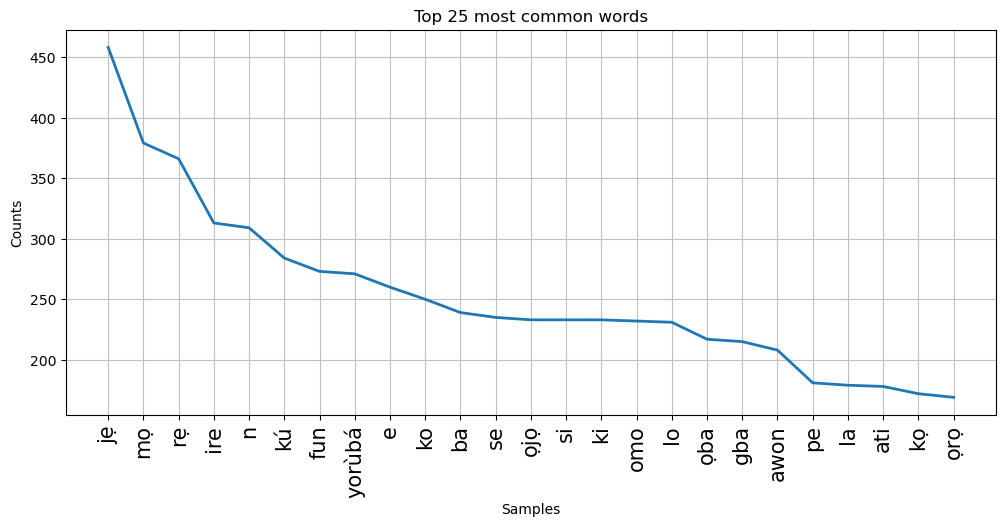

In [287]:
# visualize the most common words in the tweet column for the three languages
import nltk
all_words = []
for t in test_data['yoruba']['text_without_stopwords']:
    all_words.extend(t.split())

print(all_words[:50])
len(set(all_words))

# Frequency Distribution
freq_dist = nltk.FreqDist(all_words)

plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=15)

freq_dist.plot(25, cumulative=False)

plt.show()
